# The Beat Goes On: Using Data to Predit Heart disease

## Table of Contents

* [Introduction](#intorduction)
* [Goal](#goal)
* [Summary](#summary)
* [Exploratory Data Analysis](#eda)
  * [EDA: Descriptive Statistics](#descriptive_statistics)
  * [EDA: Descriptive Analysis](#descriptive_analysis)
* [Data Cleaning](#data_cleaning)
* [Feature Selection](#feature_selection)
* [Building a Classifier](#buidling_a_classifier)
  * [Single-Feature Training](#single_feature_training)
  * [Multi-Feature Training](#multi_feature_training)
  * [Hyperparameter Tuning](#hyperparameter_tuning)
* [Model Evaluation on Test Set](#model_evaluation_on_test_set)
* [Summary and Next Steps](#summary_and_next_steps)

## Introduction  <a name="introduction"></a>

[The World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.OurrR&D comphat focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

## Goal  <a name="goal"></a>

We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future. We're aiming at reaching an accuracy of over 80%.

## Summary  <a name="summary"></a>
Using hyperparameter tuning we created a model based on the K Nearest Neighbours algorithm, with an accuracy of `83.15%` when predicting heart disease. 

## The Data <a name="the_data"></a>

The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) has been uploaded to Kaggle by [fedesoriano](https://www.kaggle.com/fedesoriano) under the [ODbL v1.0 license](https://opendatacommons.org/licenses/odbl/1-0/).

The following is some boilerplate code that loads the required libraries, reads the data and displays some initial information about it:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Reading the file
data = pd.read_csv("heart_disease_prediction.csv")

In [3]:
data.shape

(918, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The dataset has 918 observations, each with 12 features.
There are no missing features from any of the observations.

The features are as follows:

1. `Age`: age of the patient [years]
2. `Sex`: sex of the patient [`M`: Male, `F`: Female]
3. `ChestPainType`: chest pain type [`TA`: Typical Angina, `ATA`: Atypical Angina, `NAP`: Non-Anginal Pain, `ASY`: Asymptomatic]
4. `RestingBP`: resting blood pressure [mm Hg]
5. `Cholesterol`: serum cholesterol [mm/dl]
6. `FastingBS`: fasting blood sugar [`1`: if FastingBS > 120 mg/dl, `0`: otherwise]
7. `RestingECG`: resting electrocardiogram results [`Normal`: Normal, `ST`: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), `LVH`: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
9. `ExerciseAngina`: exercise-induced angina [`Y: Yes, `N`: No]
10. `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
11. `ST_Slope`: the slope of the peak exercise ST segment [`Up`: upsloping, `Flat`: flat, `Down`: downsloping]
12. `HeartDisease`: output class [`1`: heart disease, `0`: Normal]

## Exploratory Data Analysis <a name="eda"></a>

### EDA: Descriptive Statistics <a name="descriptive_statistics"></a>

Let's display some statistics regarding the dataset's numerical features:

In [6]:
data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


From the above table we can learn a few things:
* The patients' ages range from `28` to `77`, with an average of `53.5`
* The max heart rate ranges from `60` to `202`, with an average of `136.81`
* The `Cholesterol`'s median is significantly higher than its mean (`24.2` mm/dl, or `22%` of the std). This can indicate a left-skewed distribution, or the presence of outliers that skew the distribution
* Both `RestingBP` and `Cholesterol` have a minimal value of `0`, which doesn't seem right. There may be some bad data, which would explain the obesrvation in the previous bullet point


### EDA: Descriptive Analysis <a name="descriptive_analysis"></a>

Now let's look at the categorical data:

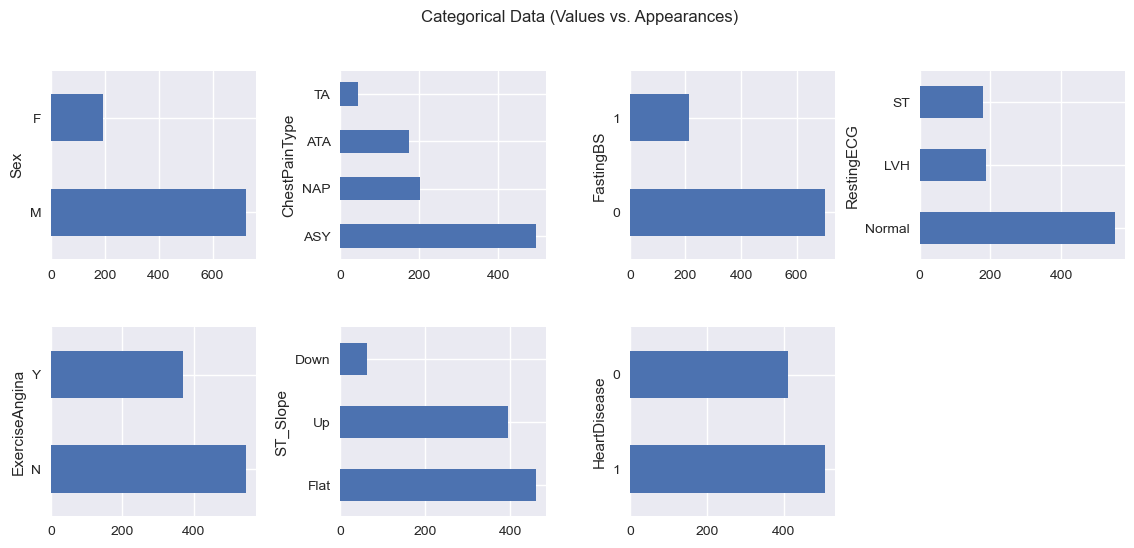

In [7]:
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
fig.suptitle("Categorical Data (Values vs. Appearances)")
fig.tight_layout(pad=3.0, rect=[0, 0.03, 1, 1.05])
fig.delaxes(fig.get_axes()[-1])

for feature, ax in zip(categorical_features, fig.get_axes()):
    data[feature].value_counts().plot.barh(ax=ax)
plt.show()

The plots above show the number of appearances of each categorical value in our dataset.

We can see that we have signifacantly more `males` than `females` (About 750 `males` and just shy of 200 `females`).

`FastingBS` divides in a similar proportion (`FastingBS` < `120 mg/dl` vs. `FastingBS` > `120 mg/dl`)

Since we're interested in the effect of the above features on heart disease, let's take another look at the above data, grouped by `HeartDisease`:

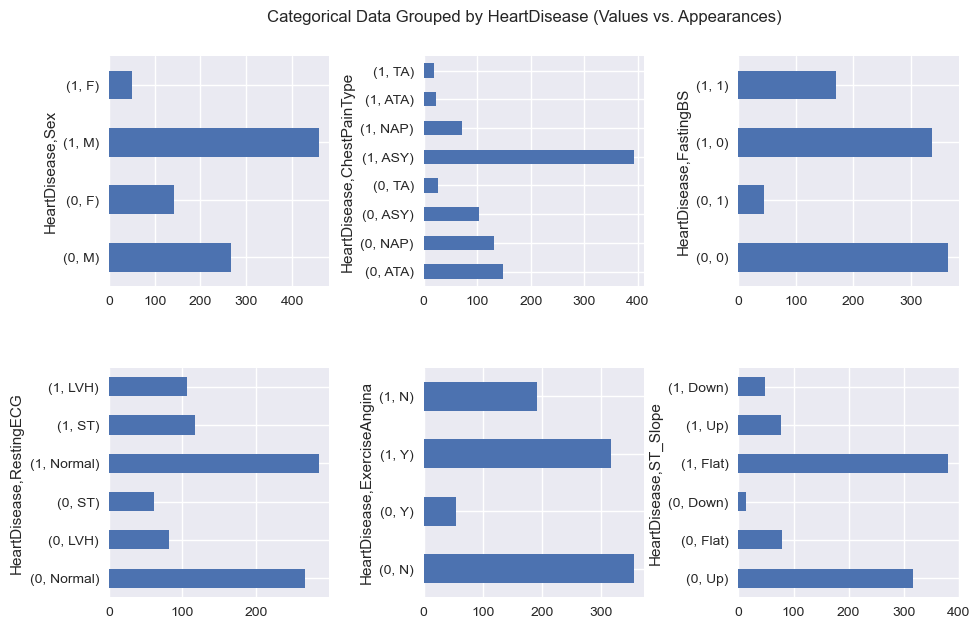

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
fig.suptitle("Categorical Data Grouped by HeartDisease (Values vs. Appearances)")
fig.tight_layout(pad=4.0, rect=[0, 0.03, 1, 1.10])

for feature, ax in zip(categorical_features[:-1], fig.get_axes()):
    data.groupby(by='HeartDisease')[feature].value_counts().plot.barh(ax=ax)
plt.show()

We can clearly see that of the patients with heart disease, a significant number are `male` and are `ASY` (Asymptomatic for chest pain).

It's also interesting to note the higher proportion of patients with `FastingBS` > `120 mg/dl` or no exercise-induced angina (`N` in `ExerciseAngina`) in the patients with a heart disease group vs the general population.

Some more notable findings:

The average age of patients who were diagnosed with heart disease:

In [9]:
print(f"{data[data['HeartDisease'] == 1]['Age'].mean():.02f}")

55.90


Here's a breakdown of the number of patients with a heart disease, by their sex and age (Are they over 60 years old?):

In [10]:
data['over_60'] = data['Age'].apply(lambda x: 'Y' if x > 60 else 'N')

In [11]:
data[data['HeartDisease'] == 1].groupby(['over_60', 'Sex']).size().unstack(fill_value=0)

Sex,F,M
over_60,,
N,31,316
Y,19,142


Most of the patients with heart disease (over 60%) are males who aren't over 50.

## Data Cleaning <a name="data_cleaning"></a>

Let's take a closer look at `RestingBP` and `Cholseterol`, as both features have a `0` value:

In [12]:
data['RestingBP'].value_counts().sort_index()

RestingBP
0       1
80      1
92      1
94      2
95      6
       ..
180    12
185     1
190     2
192     1
200     4
Name: count, Length: 67, dtype: int64

Only one observation is has a value of `0`. Let's check it out:

In [13]:
data[data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,over_60
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1,N


This obesrvation is missing the `Cholesterol` feature as well (and maybe `FastingBS`, but since `0` is a valid value for this feature we can't know for sure). It's best if we remove it from the dataset.

In [14]:
data = data.drop(index=449)

And now `Cholesterol`:

In [15]:
data['Cholesterol'].value_counts().sort_index()

Cholesterol
0      171
85       1
100      2
110      1
113      1
      ... 
491      1
518      1
529      1
564      1
603      1
Name: count, Length: 222, dtype: int64

This has significantly more missing value - `171` to be exact, or about `18.6%` of the observations.
That's too many to just remove from our datastet, so instead we'll replace that value with the median value which corresponds to the group the patient belongs to, with regards to their `Sex`, `Age_Bracket`, ST_Slope` and `HeartDisease` values, so that the data won't skew our analysis:

In [16]:
# Split the 'Age' column into decades
data['Age_Bracket'] = pd.cut(data['Age'], bins=[20, 30, 40, 50, 60, 70, 80], labels=["20s", "30s", "40s", "50s", "60s", "70s"])

In [17]:
# Get the cholesterol median of each group
medians = data.groupby(['Sex', 'Age_Bracket', 'ChestPainType', 'FastingBS', 'HeartDisease'],observed=False)['Cholesterol'].median().unstack()

In [18]:
def get_cholesterol_level(row):
    """
    Retrieve or impute a patient's cholesterol level based on available data.
    
    If the cholesterol value is present in the row, returns that value directly.
    Otherwise, imputes the cholesterol value using median values based on the 
    patient's sex, age bracket, ST slope, and heart disease status.
    
    Parameters
    ----------
    row : pandas.Series or dict-like
        A row of patient data containing the following keys:
        - 'Cholesterol': numeric or None, the patient's cholesterol measurement
        - 'Sex': categorical, patient's sex
        - 'Age_Bracket': categorical, patient's age group
        - 'ChestPainType': categorical, type of chest pain
        - 'FastingBS': binary, fasting blood sugar status
        - 'HeartDisease': binary, presence (1) or absence (0) of heart disease
    
    Returns
    -------
    float
        The patient's actual or imputed cholesterol level
    
    Notes
    -----
    Assumes the existence of a 'medians' dataframe in the outer scope with keys as
    tuples of (Sex, Age_Bracket, ChestPainType, FastingBS) and values as lists indexed by HeartDisease
    status containing the corresponding median cholesterol values.
    """
    if row['Cholesterol']:
        return row['Cholesterol']
    return int(medians.loc[(row['Sex'], row['Age_Bracket'], row['ChestPainType'], row['FastingBS'])][row['HeartDisease']])

In [19]:
data['Cholesterol'] = data.apply(get_cholesterol_level, axis=1)

## Feature Selection <a name="feature_selection"></a>

Now that we've cleaned our data, we can select features for our model. Thanks to our EDA and a general understanding of the features, we have identified the features that we're interested in:

* `Age`
* `Sex`
* `ChestPainType`
* `Cholesterol`
* `FastingBS`

We'll convert the categorical features into dummy variables:

In [20]:
# Remove unnecessary columns
data = data.drop(['over_60', 'Age_Bracket'], axis=1)

data = pd.get_dummies(data)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


Now we can look for correlations. We'd like to find at least a moderate correlation, so we'll look for correlations over 0.4:

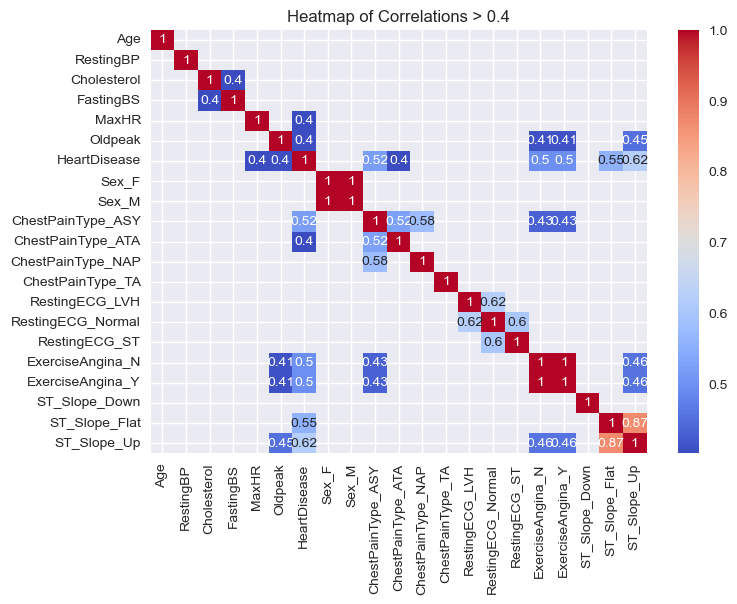

In [21]:
correlations = abs(data.corr())
sns.heatmap(correlations[correlations > 0.4], annot=True, cmap = 'coolwarm')
plt.title("Heatmap of Correlations > 0.4")
plt.show()

From the heatmap above we can identify the following features as positively correlated ( > `0.4`) to `HeartDisease`:
* `MaxHR`
* `Oldpeak`
* `ChestPainType_ASY` (Asymptomatic to Angina)
* `ChestPainType_ATA` (Typical Angina)
* `ExerciseAngina_Y` (Positive for Exercise-Induced Angina)
* `ExerciseAngina_N` (Negative for Exercise-Induced Angina)
* `ST_Slope_Flat` (Having a flat ST Slope)
* `ST_Slope_Up` (Having an Upsloping ST Slope)

Surprisingly enough, `Cholesterol` isn't correlated with `HeartDisease` according to the dataset.
We'll remove both `ExerciseAngina` features, since if they are both correlated with `HeartDisease` then it's not a relevant feature.
But we'll add `Sex_M` to the list, since even though it's not strongly correlated to `HeartDisease`, our EDF has shown that there's a higher proportion of males in the group that's positive for `HeartDisease`, so we'll take that into account as well.

So our final list is:
* `MaxHR`
* `Oldpeak`
* `ChestPainType_ASY` (Asymptomatic to Angina)
* `ChestPainType_ATA` (Typical Angina)
* `ST_Slope_Flat` (Having a flat ST Slope)
* `ST_Slope_Up` (Having an Upsloping ST Slope)
* `Sex_M` (patient is male)

## Building a Classifier <a name="buidling_a_classifier"></a>

### Single-Feature Training <a name="single_feature_training"></a>

Now that we've identified the relevant features we can create and train multiple models, using one of those features at a time.

In [22]:
# Split the dataset into training and validation sets. Setting random_state to a set number, for reproducibility
X = data.drop(["HeartDisease"], axis=1)
y = data["HeartDisease"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2024)

In [23]:
relevant_features = ['MaxHR', 'Oldpeak', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ST_Slope_Flat', 'ST_Slope_Up', 'Sex_M']

# Create a dictionary to temporarily store the results
results = {}

for feature in relevant_features:
    results[feature] = {}  # Initialize nested dictionary for each feature
    # Run the KNN algorithm on a selection of number of neighbours
    for num in [1, 3, 5, 8, 10, 13]:
        knn = KNeighborsClassifier(n_neighbors = num)
        knn.fit(X_train[[feature]], y_train)
        results[feature][num] = knn.score(X_val[[feature]], y_val)

# Convert to DataFrame
accuracies = pd.DataFrame(results).T  # .T transposes to get features as index
print(f"The accuracies calculated are:")
print(accuracies)
    

The accuracies calculated are:
                         1         3         5         8         10        13
MaxHR              0.557971  0.579710  0.579710  0.608696  0.601449  0.659420
Oldpeak            0.543478  0.565217  0.601449  0.731884  0.572464  0.572464
ChestPainType_ASY  0.586957  0.586957  0.586957  0.768116  0.768116  0.768116
ChestPainType_ATA  0.586957  0.586957  0.586957  0.753623  0.413043  0.753623
ST_Slope_Flat      0.826087  0.826087  0.826087  0.826087  0.826087  0.826087
ST_Slope_Up        0.855072  0.855072  0.855072  0.855072  0.855072  0.855072
Sex_M              0.659420  0.659420  0.659420  0.659420  0.659420  0.659420


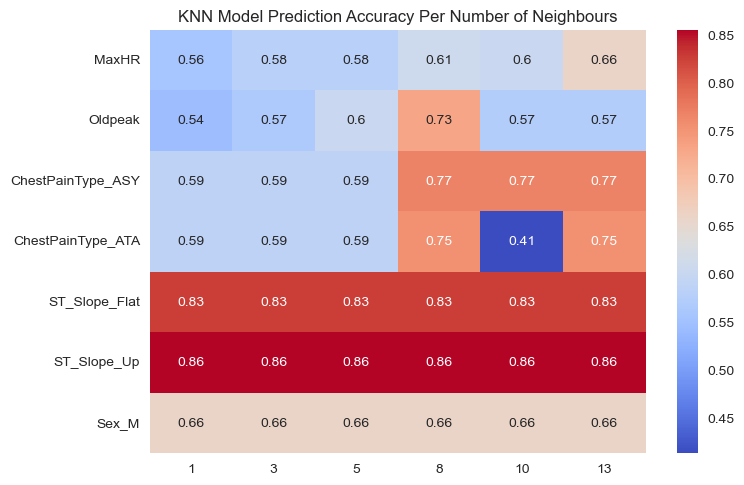

In [24]:
sns.heatmap(accuracies, annot=True, cmap = 'coolwarm')
plt.title("KNN Model Prediction Accuracy Per Number of Neighbours")
plt.show()

We've trained a K-NN model using 7 different features and 6 different numbers of neighbours.

For most of them, the accuracy plateaued once it reached a certain number of neighbours. That probably happens because we don't have enough data points.

We got the highest accuracy using `ST_Slope_Up` and `ST_Slope_Flat`, with any number of neighbours (`86%` and `83%`, respectively), with `ChestPainType_ASY`, `ChestPainType_ATA` and `Oldpeak` with slightly lower accuracies (`77%`, `75%` and `73%`, respectively).

`MaxHR` and `Sex_M` got less than 70% accuracy, so it seems that they're not as useful for our purposes.

### Multi-Feature Training <a name="multi_feature_training"></a>

We'd like to check how these numbers will fare if we trained our model on multiple features instead of one-at-a-time.

To do that we'll need to scale all the features:

In [25]:
# Create the scaler
scaler = MinMaxScaler()
# Fit and transform the features in the training set using the scaler
X_train_scaled = scaler.fit_transform(X_train[relevant_features])
# Transform the features in the validation set
X_val_scaled = scaler.transform(X_val[relevant_features])
# Create a k-NN model using 8 neighbours (the number that provided the best accuracy using the previous method)
n_neighbours = 8
knn = KNeighborsClassifier(n_neighbors = n_neighbours)
# Fit the model to the training data on the scaled features
knn.fit(X_train_scaled, y_train)
#Evaluate the model on the scaled features in the validation set
print(f"validation accuracy for {n_neighbours}: {knn.score(X_val_scaled, y_val)*100:.2f}%")

validation accuracy for 8: 89.86%


We can clearly see that using all the features resulted in a better accuracy of the model, relative to single-feature (`89.86%` vs. `86%`, almost 4 percentage points increase).

### Hyperparameter Tuning <a name="hyperparameter_tuning"></a>

Can we get an even better accuracy by tuning our parameters? Let's check.

In [26]:
# Split the dataset into training and test sets. Setting random_state to a set number, for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Fit and transform the features in the training set using the scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[relevant_features])

# Create a dictionary that stores the parameters and values we want to search over as key-value pairs
# We'll use:
# n_neighbours ranging from 1 to 19.
# Two metrics - Minkowski (the default metric used in KNeighborsClassifier) and Manhattan
# Two weights methods - uniform (the default metric) and distance (weight equals 1/distance)
grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"],
               'weights': ['uniform', 'distance']
              }

# Instantiate a k-NN model
knn = KNeighborsClassifier()
#Create a GridSearchCV instance using the above model and the dictionary
knn_grid = GridSearchCV(knn, grid_params, scoring="accuracy")
#Fit the above instance on the scaled features and corresponding labels
knn_grid.fit(X_train_scaled, y_train)

print(f"The best accuracy: {knn_grid.best_score_*100:.2f}%") 
print(f"Achieved using the following parameters: {knn_grid.best_params_}")

The best accuracy: 86.76%
Achieved using the following parameters: {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'uniform'}


Interesstingly enough, the best model we got from running the grid search isn't as accurate as the one we created manually (`86.76%` vs. `89.86%`).
The difference is probably due to the fact that `GridSearchCV` uses [cross-validation](https://towardsdatascience.com/cross-validation-and-grid-search-efa64b127c1b).
Since cross-validation usually provides a better estimate of how the model performs compared to the prior approach, we'll use the model found above.

## Model Evaluation on Test Set <a name="model_evaluation_on_test_set"></a>

Now that we have a model we can test it on our test set to evaluate its behaviour on unseen data (the test set). This step is crucial because:

1. It tells us how well our model generalizes to new, unseen data
2. It helps detect if we're overfitting (performing much better on training than test data)
3. It provides a realistic estimate of the model's performance in production

### What we're doing:
1. Scaling the test features using the same scaler that was fit on the training data
2. Using our tuned model to make predictions on the scaled test data
3. Calculating the accuracy score to measure performance

Note: We use the same scaler that was fit on the training data to maintain consistency in how features are standardized. This prevents data leakage and ensures our evaluation is valid.

In [27]:
# scale the relevant features of the test set
X_test_scaled = scaler.transform(X_test[relevant_features])

# Predict the model's output on the scaled features from the test set using the best estimate
prediction = knn_grid.best_estimator_.predict(X_test_scaled)

# Get the accuracy of the model's prediction
accuracy = accuracy_score(y_test, prediction)

print(f"The model's accuracy running on the test set: {accuracy*100:.2f}%")

The model's accuracy running on the test set: 83.15%


Our model got an accuracy of `83.15%`, which is lower than expected, but still quite good. This could suggest that the model is overfitting to the training data.

As a final step, let's check how each feature impacts our model predicions.

We'll do that by using permutation importance. For each feature we'll:

* Randomly shuffle the values of that feature in the test set
* Measure how much the model's performance drops
* Repeat this process 10 times for stability
* A larger drop in performance indicates higher feature importance

In [ ]:
# Calculate feature importance through permutation
feature_importance = []
n_repeats = 10

for feature_idx, feature_name in enumerate(relevant_features):
    importance_scores = []
    
    for _ in range(n_repeats):
        # Create a copy of test data
        X_test_permuted = X_test_scaled.copy()
        
        # Permute the feature
        np.random.shuffle(X_test_permuted[:, feature_idx])
        
        # Calculate permuted score
        prediction = knn_grid.best_estimator_.predict(X_test_permuted)
        permuted_score = accuracy_score(y_test, prediction)
        
        # Calculate importance (decrease in performance)
        importance = accuracy - permuted_score
        importance_scores.append(importance)
    
    # Average importance over repeats
    mean_importance = np.mean(importance_scores)
    std_importance = np.std(importance_scores)
    feature_importance.append((feature_name, mean_importance, std_importance))

# Create DataFrame with results
importance_df = pd.DataFrame(feature_importance, 
                           columns=['Feature', 'Importance', 'Std'])
importance_df = importance_df.sort_values('Importance', ascending=False)



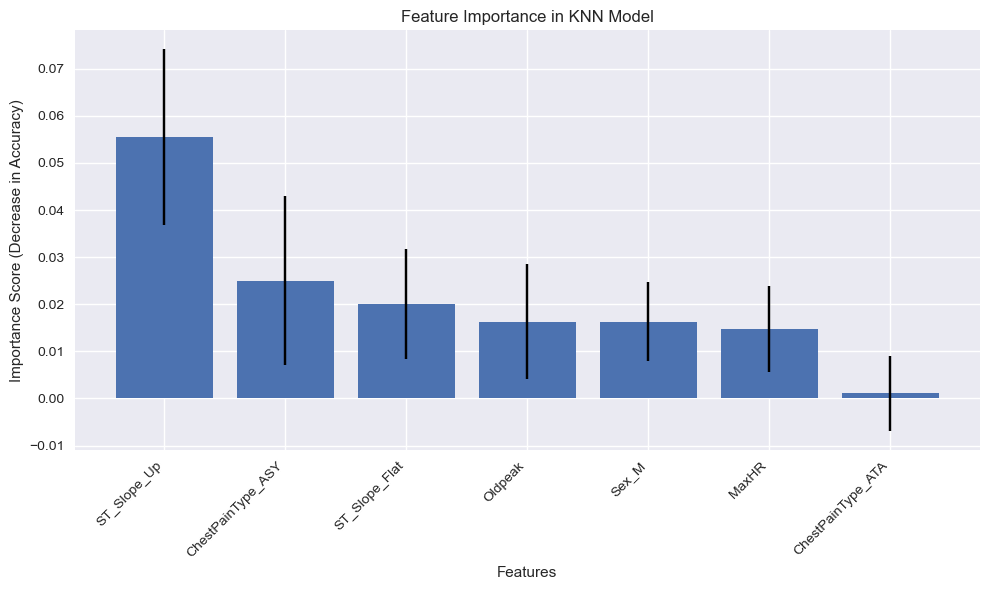

In [37]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.errorbar(importance_df['Feature'], importance_df['Importance'], 
            yerr=importance_df['Std'], fmt='none', color='black', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score (Decrease in Accuracy)')
plt.title('Feature Importance in KNN Model')
plt.tight_layout()
plt.show()

From the above we see that:
* The most important feature in predicting a heart disease is `ST_Slope_Up` (upsloping ST Slope). Without it, the model's accuracy drops by about 5.5 percentage points
* `ChestPainType_ATA` has a negligible effect on the model, and can probably be removed from it to reduce complexity with a minimal impact on its accuracy
* Each of the other features affects the accuracy by 1.5-2.5 percentage points

## Summary and Next Steps <a name="summary_and_next_steps"></a>

The final model was trained using the following features:

* `MaxHR`
* `Oldpeak`
* `ChestPainType_ASY` (Asymptomatic to Angina)
* `ChestPainType_ATA` (Typical Angina)
* `ST_Slope_Flat` (Having a flat ST Slope)
* `ST_Slope_Up` (Having an Upsloping ST Slope)
* `Sex_M` (patient is male)

Using the hyperparameter tuning method we came up with a K Nearest Neighbours model, using the following parameters:
* `metric`: `minkowski`
* `n_neighbors`: 15
*  `weights`: `uniform`

Using that model we got an accuracy of `83.15%`, which is promising, but can be improved on.
Our manually created model has shown a higher accuracy when tested against validation data, but that was probably coincidental. 
The GridsearchCV algorithm uses cross-validation, which is more indicative of real-world performance.

To improve the model we can try the following:
* Collect more data
* Try out different features (by lowering or increasing the bar for the correlation)
* Try algorithms other than KNN
* Expand our grid search to identify more optimal hyperparameters

We should also have a look at the model's confusion matrix, to identify the size of its Type I and Type II errors, and consider those as well.